# SAGE Models to Compute Heritage Values and Attributes

## Imports

In [1]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import pandas as pd

import random

import torch
torch.manual_seed(1337)
torch.backends.cudnn.benchmark = True

from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, to_hetero
from torch_geometric.utils import to_undirected

import torch.nn.functional as F
from torch_geometric import seed_everything

from tqdm import tqdm
import torch.optim as optim
import pickle

In [3]:
from torch_geometric.nn import SAGEConv
from torch_cluster import knn_graph

In [4]:
os.getcwd()

'D:\\surf\\TUD\\Paper\\Venice_Graph'

In [5]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
args = Namespace(
    # Data and Path information
    path = 'dataset/Venice',
    save_dir='model_storage/SAGE/',
    model_state_file='model.pth',
    
    # Model hyper parameters
    hidden_channels = 128,
    num_layers = 3,
    k=3,
    use_gdc=True,
    
    # Training hyper parameters
    sample_nodes = 25,
    batch_size=32,
    early_stopping_criteria=30,
    learning_rate=0.001,
    l2=2e-4,
    dropout_p=0.5,
    num_epochs=300,
    seed=42,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [9]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# handle dirs
handle_dirs(args.save_dir)    

Expanded filepaths: 
	model_storage/SAGE/model.pth


## Constructing Dataset

In [10]:
class VEN(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [10]:
class VEN_Homo(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_Homo is a homogeneous graph containing 2951 nodes and 1,071,977 links.
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [16]:
class VEN_XL(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [17]:
class VEN_XL_Homo(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [11]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.NormalizeFeatures()
dataset = VEN_Homo('dataset/Venice_Homo')
data = dataset[0]

In [12]:
data.n_id = torch.arange(data.num_nodes)
data = data.to(device)
data

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977], n_id=[2951])

In [13]:
data.x

tensor([[1.2861, 0.3745, 1.1453,  ..., 1.0000, 0.0000, 0.0000],
        [0.3977, 0.1582, 0.3059,  ..., 1.0000, 0.0000, 0.0000],
        [0.5185, 0.5124, 1.3662,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.0124, 1.7083, 0.3258,  ..., 0.0000, 1.0000, 0.0000],
        [0.4402, 0.8374, 0.4974,  ..., 0.0000, 1.0000, 0.0000],
        [0.2102, 1.5535, 0.3352,  ..., 0.0000, 1.0000, 0.0000]],
       device='cuda:0')

## Data Loader for Sampling

In [14]:
from torch_geometric.loader import NeighborLoader

In [15]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [16]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [17]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [18]:
sampled_data = next(iter(train_loader))
batch = sampled_data
batch

Data(num_nodes=2931, x=[2931, 1753], y=[2931, 20], node_type=[2931], att_lab=[2931], val_lab=[2931], train_mask=[2931], val_mask=[2931], test_mask=[2931], edge_index=[2, 103428], edge_attr=[103428], n_id=[2931], batch_size=32)

In [19]:
batch['train_mask'].sum()

tensor(361, device='cuda:0')

In [20]:
batch.x.shape

torch.Size([2931, 1753])

In [21]:
batch.y.shape

torch.Size([2931, 20])

## Helper Function

In [22]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_ATT_acc_val': 0,
            'early_stopping_best_VAL_acc_val': 0,
            'early_stopping_best_ATT_acc_val_2': 0,
            'early_stopping_lowest_loss': 1000,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_ATT_loss': [],
            'train_VAL_loss':[],
            'train_ATT_acc': [],
            'train_VAL_acc': [],
            'train_VAL_jac': [],
            'train_VAL_acc_1':[], 
            'val_loss': [],
            'val_ATT_loss': [],
            'val_VAL_loss':[],
            'val_ATT_acc': [],
            'val_VAL_acc': [],
            'val_VAL_jac': [],
            'val_VAL_acc_1': [],
            'test_loss': -1,
            'test_ATT_loss': -1,
            'test_VAL_loss':-1,
            'test_ATT_acc': -1,
            'test_VAL_acc': -1,
            'test_VAL_jac': -1,
            'test_VAL_acc_1': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        ATT_acc_tm1, ATT_acc_t = train_state['val_ATT_acc'][-2:]
        #ATT_acc_2_tm1, ATT_acc_2_t = train_state['val_ATT_acc_2'][-2:]
        VAL_acc_tm1, VAL_acc_t = train_state['val_VAL_acc'][-2:]
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If accuracy worsened
        #if loss_t >= train_state['early_stopping_lowest_loss']:
        #    train_state['early_stopping_step'] += 1
        
        if ATT_acc_t <= train_state['early_stopping_best_ATT_acc_val'] and VAL_acc_t <= train_state['early_stopping_best_VAL_acc_val']:# and ATT_acc_2_t <= train_state['early_stopping_best_ATT_acc_val_2']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if VAL_acc_t > train_state['early_stopping_best_VAL_acc_val']:
                train_state['early_stopping_best_VAL_acc_val'] = VAL_acc_t
                
            if ATT_acc_t > train_state['early_stopping_best_ATT_acc_val']:
                train_state['early_stopping_best_ATT_acc_val'] = ATT_acc_t
            
            #if ATT_acc_2_t > train_state['early_stopping_best_ATT_acc_val_2']:
            #    train_state['early_stopping_best_ATT_acc_val_2'] = ATT_acc_2_t
                
            if loss_t < train_state['early_stopping_lowest_loss']:
                train_state['early_stopping_lowest_loss'] = loss_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [23]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [24]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

## Searched Best Hyper-Parameter

In [23]:
with open(args.save_dir+'42/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [24]:
len(hyperdict)

135

In [25]:
hyper_df = pd.DataFrame(hyperdict).T

In [26]:
hyper_df[(hyper_df.early_stopping_lowest_loss<4.14)]

stop_early early_stopping_step  \
0.1 3 512 0.0010       True                  30   
    5 512 0.0001       True                  30   
0.3 3 512 0.0001       True                  30   

                 early_stopping_best_ATT_acc_val  \
0.1 3 512 0.0010                       90.503597   
    5 512 0.0001                       89.784173   
0.3 3 512 0.0001                       89.928058   

                 early_stopping_best_VAL_acc_val  \
0.1 3 512 0.0010                       98.129496   
    5 512 0.0001                       96.690647   
0.3 3 512 0.0001                       94.676259   

                 early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0.1 3 512 0.0010                                 0                   4.138431   
    5 512 0.0001                                 0                   4.139175   
0.3 3 512 0.0001                                 0                     4.1395   

                 learning_rate epoch_index  \
0.1 3 512 0.0010         0.001         140   
    5 512 0.0001        0.0001         208   
0.3 3 512 0.0001        0.0001         163   

                                                         train_loss  \
0.1 3 512 0.0010  [3.9107560515403748, 3.575341443220774, 3.3046...   
    5 512 0.0001  [4.131787121295929, 3.7653501431147256, 3.7225...   
0.3 3 512 0.0001  [4.014001568158467, 3.684295117855072, 3.60325...   

                                                     train_ATT_loss  ...  \
0.1 3 512 0.0010  [1.9028614198071805, 1.700502701743488, 1.3999...  ...   
    5 512 0.0001  [1.956105706103951, 1.928340225008386, 1.90353...  ...   
0.3 3 512 0.0001  [1.8947085921453968, 1.8424101859909015, 1.769...  ...   

                                                        val_VAL_acc  \
0.1 3 512 0.0010  [50.50359712230216, 60.86330935251799, 85.4676...   
    5 512 0.0001  [81.00719424460432, 81.00719424460432, 34.3884...   
0.3 3 512 0.0001  [83.02158273381295, 89.92805755395683, 68.7769...   

                                                        val_VAL_jac test_loss  \
0.1 3 512 0.0010  [0.13347722231912956, 0.13585132146053178, 0.1...        -1   
    5 512 0.0001  [0.13347722231912956, 0.13347722231912956, 0.1...        -1   
0.3 3 512 0.0001  [0.13347722231912956, 0.13347722231912956, 0.1...        -1   

                 test_ATT_loss test_VAL_loss test_ATT_acc test_ATT_acc_2  \
0.1 3 512 0.0010            -1            -1           -1             -1   
    5 512 0.0001            -1            -1           -1             -1   
0.3 3 512 0.0001            -1            -1           -1             -1   

                 test_VAL_acc test_VAL_jac                model_filename  
0.1 3 512 0.0010           -1           -1  model_storage/SAGE/model.pth  
    5 512 0.0001           -1           -1  model_storage/SAGE/model.pth  
0.3 3 512 0.0001           -1           -1  model_storage/SAGE/model.pth  

[3 rows x 29 columns]

In [31]:
(hyper_df['val_VAL_loss'].apply(lambda x: min(x)) + hyper_df['val_ATT_loss'].apply(lambda x: min(x))).index[44]

(0.1, 5, 512, 0.0001)

## Re-run model and get Inference Data

In [25]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super().__init__()
        self.num_layers = num_layers
        self.p = dropout
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers-1):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=self.p, training=self.training)
        return x

In [26]:
def train_Homo(model, optimizer, train_loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = args.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        loss = F.cross_entropy(out_att, y_att[:batch_size]) + F.cross_entropy(out_val, y_val[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [27]:
@torch.no_grad()
def test_Homo(model, loader):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_1_val = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]
    
    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [28]:
def initialization():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0].to(device)
    data.n_id = torch.arange(data.num_nodes)
    data = data.to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = SAGE(in_channels=data.x.shape[-1], hidden_channels = 512, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=5).to(device)
    return data, model, train_loader, val_loader, test_loader

In [29]:
def training_loop(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop(verbose=True)

In [38]:
train_state

{'stop_early': True,
 'early_stopping_step': 30,
 'early_stopping_best_ATT_acc_val': 96.7479674796748,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.674814448439726,
 'learning_rate': 0.001,
 'epoch_index': 169,
 'train_loss': [4.098931749661763,
  3.767206331094106,
  3.7242619395256042,
  3.700642983118693,
  3.668950080871582,
  3.6377055446306863,
  3.6117473045984902,
  3.5522724787394204,
  3.4761929710706077,
  3.3616212805112204,
  3.23332671324412,
  3.1092602411905923,
  3.028814951578776,
  2.898661951224009,
  2.82891054948171,
  2.812813639640808,
  2.7504736383756003,
  2.733060439427694,
  2.6882276137669883,
  2.664868414402008,
  2.642411748568217,
  2.6827587683995566,
  2.6409761110941568,
  2.5932233532269797,
  2.5788277784983316,
  2.548888703187307,
  2.53569761912028,
  2.5417450070381165,
  2.529538651307424,
  2.5021569530169168,
  2.4645569125811257,
  2.4980392257372537,
  2.5012814203898

In [30]:
model = SAGE(in_channels=data.x.shape[-1], hidden_channels = 512, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=5).to(device)

In [31]:
model.load_state_dict(torch.load(args.save_dir+'SAGE_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [41]:
model

SAGE(
  (convs): ModuleList(
    (0): SAGEConv(1753, 512)
    (1): SAGEConv(512, 512)
    (2): SAGEConv(512, 512)
    (3): SAGEConv(512, 512)
    (4): SAGEConv(512, 20)
  )
)

In [42]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 12.95it/s]


In [43]:
test_Homo(model, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.60it/s]


(0.727577265444885,
 1.6139437128632352,
 100.0,
 99.44598337950139,
 0.8111726755580744,
 83.93351800554017)

In [44]:
test_Homo(model, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 14.42it/s]


(0.7921790241952834,
 1.627505142700496,
 96.13821138211382,
 100.0,
 0.779967164758391,
 79.80295566502463)

In [45]:
test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 13.37it/s]


(0.7921501777281107,
 1.6524048553158839,
 97.01789264413519,
 99.47916666666667,
 0.7413194502393404,
 80.20833333333333)

In [46]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.30it/s]


In [47]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [48]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.792034,1.627620,95.711382,99.950739,0.771675,80.689655
std,0.000524,0.000174,0.223680,0.155777,0.003974,0.763149
min,0.791345,1.627426,95.325203,99.507389,0.766831,79.310345
25%,0.791626,1.627471,95.528455,100.000000,0.768678,80.295567
50%,0.792003,1.627631,95.731707,100.000000,0.770525,80.788177
75%,0.792291,1.627699,95.934959,100.000000,0.774220,81.280788
max,0.793165,1.627940,95.934959,100.000000,0.777504,81.773399


In [49]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.792685,1.652345,97.077535,9.947917e+01,0.754774,79.062500
std,0.000627,0.000295,0.230517,1.497956e-14,0.005164,0.685709
min,0.791774,1.651828,96.620278,9.947917e+01,0.744792,78.125000
25%,0.792228,1.652276,97.017893,9.947917e+01,0.752170,78.645833
50%,0.792665,1.652408,97.117296,9.947917e+01,0.754340,79.166667
75%,0.793224,1.652524,97.216700,9.947917e+01,0.758247,79.557292
max,0.793595,1.652687,97.415507,9.947917e+01,0.762153,80.208333


In [50]:
val_df.to_csv(args.save_dir + 'val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'test_metrics.csv', sep='\t')

In [51]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [52]:
train_state

{'stop_early': True,
 'early_stopping_step': 30,
 'early_stopping_best_ATT_acc_val': 96.7479674796748,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.674814448439726,
 'learning_rate': 0.001,
 'epoch_index': 169,
 'train_loss': [4.098931749661763,
  3.767206331094106,
  3.7242619395256042,
  3.700642983118693,
  3.668950080871582,
  3.6377055446306863,
  3.6117473045984902,
  3.5522724787394204,
  3.4761929710706077,
  3.3616212805112204,
  3.23332671324412,
  3.1092602411905923,
  3.028814951578776,
  2.898661951224009,
  2.82891054948171,
  2.812813639640808,
  2.7504736383756003,
  2.733060439427694,
  2.6882276137669883,
  2.664868414402008,
  2.642411748568217,
  2.6827587683995566,
  2.6409761110941568,
  2.5932233532269797,
  2.5788277784983316,
  2.548888703187307,
  2.53569761912028,
  2.5417450070381165,
  2.529538651307424,
  2.5021569530169168,
  2.4645569125811257,
  2.4980392257372537,
  2.5012814203898

In [53]:
with open(args.save_dir+'SAGE_best_model/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open(args.save_dir+'SAGE_best_model/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [55]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [56]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

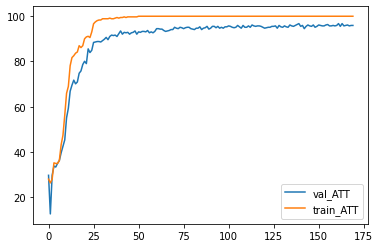

In [57]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

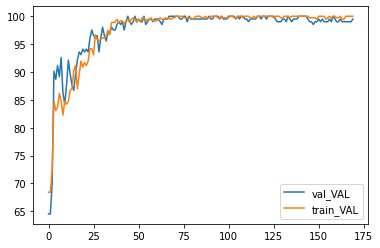

In [58]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

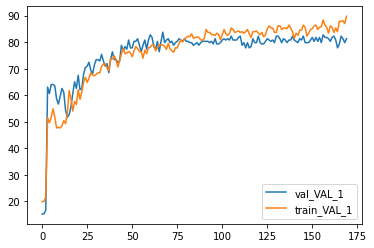

In [59]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

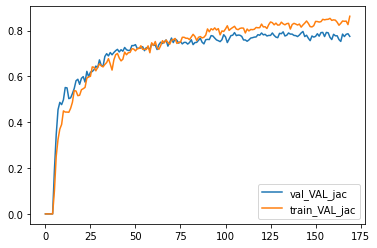

In [60]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [61]:
unlabel_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data.train_mask + data.val_mask + data.test_mask),
)

In [62]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [63]:
pred_train = predict_Homo(model, train_loader)
pred_val = predict_Homo(model, val_loader)
pred_test = predict_Homo(model, test_loader)
pred_unlab = predict_Homo(model, unlabel_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 22.56it/s]


In [64]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [65]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [66]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [67]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.021085,0.080077,0.015716,0.004451,0.212755,0.075620,0.037683,0.004144,0.548468,0.085739,0.365993,0.173247,0.236994,0.015982,0.098432,0.004647,0.004069,0.003527,0.003366,0.008006
1.0,0.007347,0.030522,0.007316,0.001726,0.056869,0.034187,0.009252,0.001284,0.851497,0.153359,0.434726,0.139513,0.161096,0.009869,0.081890,0.004033,0.003355,0.002760,0.002715,0.006684
2.0,0.038959,0.089459,0.013668,0.009166,0.255841,0.180218,0.051883,0.005855,0.354952,0.139353,0.401640,0.158797,0.161027,0.009512,0.107023,0.004194,0.004084,0.003055,0.003088,0.008226
3.0,0.049263,0.243927,0.023052,0.018801,0.015961,0.050762,0.547270,0.043546,0.007417,0.049004,0.041706,0.139258,0.069855,0.015055,0.655422,0.006946,0.005289,0.003414,0.005688,0.008363
4.0,0.226045,0.307158,0.010621,0.060181,0.009664,0.304781,0.042088,0.018450,0.021013,0.194195,0.066356,0.092250,0.198467,0.018021,0.398030,0.006777,0.005326,0.003530,0.005200,0.011848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.027497,0.447962,0.065789,0.030700,0.007843,0.031089,0.337795,0.037865,0.013461,0.337518,0.171166,0.189892,0.195490,0.011729,0.059820,0.006806,0.006765,0.004519,0.005840,0.010456
2947.0,0.004697,0.018286,0.223953,0.013178,0.003370,0.003730,0.640505,0.088873,0.003408,0.291351,0.151943,0.220524,0.195674,0.013143,0.084207,0.008385,0.007127,0.005984,0.009803,0.011858
2948.0,0.052124,0.565919,0.038446,0.033455,0.009417,0.039590,0.222424,0.028003,0.010621,0.322396,0.202790,0.193366,0.181756,0.010406,0.056317,0.006385,0.006474,0.004193,0.005828,0.010089


In [68]:
preds_df.to_csv(args.save_dir + 'preds.csv', sep='\t')

In [69]:
states.to_csv(args.save_dir + 'train_state.csv', sep='\t')

## Per-Class Metrics

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
preds = pd.read_csv(args.save_dir + 'preds.csv', sep='\t', index_col='0')

In [72]:
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.021085,0.080077,0.015716,0.004451,0.212755,0.075620,0.037683,0.004144,0.548468,0.085739,0.365993,0.173247,0.236994,0.015982,0.098432,0.004647,0.004069,0.003527,0.003366,0.008006
1.0,0.007347,0.030522,0.007316,0.001726,0.056869,0.034187,0.009252,0.001284,0.851497,0.153359,0.434726,0.139513,0.161096,0.009869,0.081890,0.004033,0.003355,0.002760,0.002715,0.006684
2.0,0.038959,0.089459,0.013668,0.009166,0.255841,0.180218,0.051883,0.005855,0.354952,0.139353,0.401640,0.158797,0.161027,0.009512,0.107023,0.004194,0.004084,0.003055,0.003088,0.008226
3.0,0.049263,0.243927,0.023052,0.018801,0.015961,0.050762,0.547270,0.043546,0.007417,0.049004,0.041706,0.139258,0.069855,0.015055,0.655422,0.006946,0.005289,0.003414,0.005688,0.008363
4.0,0.226045,0.307158,0.010621,0.060181,0.009664,0.304781,0.042088,0.018450,0.021013,0.194195,0.066356,0.092250,0.198467,0.018021,0.398030,0.006777,0.005326,0.003530,0.005200,0.011848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.027497,0.447962,0.065789,0.030700,0.007843,0.031089,0.337795,0.037865,0.013461,0.337518,0.171166,0.189892,0.195490,0.011729,0.059820,0.006806,0.006765,0.004519,0.005840,0.010456
2947.0,0.004697,0.018286,0.223953,0.013178,0.003370,0.003730,0.640505,0.088873,0.003408,0.291351,0.151943,0.220524,0.195674,0.013143,0.084207,0.008385,0.007127,0.005984,0.009803,0.011858
2948.0,0.052124,0.565919,0.038446,0.033455,0.009417,0.039590,0.222424,0.028003,0.010621,0.322396,0.202790,0.193366,0.181756,0.010406,0.056317,0.006385,0.006474,0.004193,0.005828,0.010089


In [73]:
pred = torch.tensor(np.array(preds)).to(device)

In [74]:
pred.shape

torch.Size([2951, 20])

In [75]:
data.y.shape

torch.Size([2951, 20])

In [76]:
data.y[data.test_mask].shape

torch.Size([695, 20])

In [77]:
pred[data.test_mask].shape

torch.Size([695, 20])

In [78]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [79]:
test_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.test_mask][:,9:].cpu(),3)).astype(int)

In [80]:
test_ATT_conf

array([[ 64,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 144,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,  10,   0,   0,   0,   0,   1,   0],
       [  2,   0,   0,  16,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  71,   0,   1,   0,   0],
       [  0,   2,   0,   0,   0, 100,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0,  74,   1,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   1,   0,   0,   0,  10]], dtype=int64)

In [81]:
test_VAL_conf

array([[53,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 21,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  5, 17,  7,  0,  4,  0,  0,  0,  0,  0],
       [ 1,  2,  2, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  4,  3,  0, 33,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [82]:
test_VAL_conf_k

array([[ 90,  59,  54,  42,   0,  37,   0,   0,   0,   0,   0],
       [ 52,  85,  77,  63,   0,  32,   0,   0,   0,   0,   0],
       [ 57,  79, 120,  88,   0,  64,   0,   0,   0,   0,   0],
       [ 54,  75,  92, 116,   0,  62,   0,   0,   0,   0,   0],
       [  0,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 46,  35,  73,  72,   0,  83,   0,   0,   0,   0,   0],
       [  2,   0,   2,   0,   0,   2,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [83]:
val_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu(), 
                                pred[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.val_mask][:,9:].cpu(),3)).astype(int)

In [84]:
val_ATT_conf

array([[ 61,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 143,   0,   0,   1,   1,   0,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  21,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,  74,   0,   0,   0,   0],
       [  1,   1,   0,   0,   1, 100,   0,   0,   0],
       [  0,   2,   0,   0,   1,   0,  59,   0,   0],
       [  1,   0,   3,   0,   0,   0,   1,   0,   0],
       [  0,   1,   0,   0,   2,   2,   0,   0,   5]], dtype=int64)

In [85]:
val_VAL_conf

array([[65,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 13,  1,  3,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  3, 18,  5,  0,  4,  0,  0,  0,  0,  0],
       [ 1,  2,  0, 30,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  5,  0,  2,  0, 37,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [86]:
val_VAL_conf_k

array([[102,  70,  52,  53,   0,  47,   0,   0,   0,   0,   0],
       [ 60,  88,  66,  66,   2,  39,   0,   0,   0,   0,   0],
       [ 55,  66, 111,  88,   0,  73,   0,   0,   0,   0,   0],
       [ 68,  88,  95, 118,   2,  55,   0,   0,   0,   0,   0],
       [  0,   8,   6,   8,   2,   0,   0,   0,   0,   0,   0],
       [ 51,  43,  87,  66,   0,  92,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [87]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k.csv')

In [88]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [89]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [90]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']

In [91]:
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [92]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [93]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [94]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         1.000000  0.969697   
          Urban Form Elements                       0.993103  0.966443   
          Gastronomy                                0.909091  0.833333   
          Interior Scenery                          0.888889  1.000000   
          Natural Features and Land-scape Scenery   0.986111  0.986111   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.000000  0.000000   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.000000  0.000000   
          Criterion x                               0.000000  0.000000   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.984615  
          Urban Form Elements                      0.979592  
          Gastronomy                               0.869565  
          Interior Scenery                         0.941176  
          Natural Features and Land-scape Scenery  0.986111  
...                                                     ...  
val_VAL_k Criterion vii                            0.000000  
          Criterion viii                           0.000000  
          Criterion ix                             0.000000  
          Criterion x                              0.000000  
          Others                                   0.000000  

[62 rows x 3 columns]

In [95]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

## Explanation

In [32]:
from torch_geometric.nn import GNNExplainer

In [33]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')

In [34]:
def explain_features(model, loader):
    model.eval()
    seed_everything(args.seed)
    explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
    all_preds = {}
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        for node_idx in tqdm(range(batch_size)):
            node_feat_mask, _ = explainer.explain_node(node_idx, batch.x, edge_index)
            all_preds[batch.n_id[node_idx]] = node_feat_mask
    
    out = torch.vstack([torch.hstack([i, all_preds[i]]) for i in all_preds.keys()])
    return out

In [ ]:
train_explain = explain_features(model, train_loader)

In [ ]:
val_explain = explain_features(model, val_loader)

In [ ]:
test_explain = explain_features(model, test_loader)

In [38]:
train_explain_df = pd.DataFrame(train_explain.cpu()).sort_values(0).set_index(0)

In [39]:
val_explain_df = pd.DataFrame(val_explain.cpu()).sort_values(0).set_index(0)

In [40]:
test_explain_df = pd.DataFrame(test_explain.cpu()).sort_values(0).set_index(0)

In [41]:
all_explain_df = pd.concat([train_explain_df, val_explain_df, test_explain_df]).reset_index().rename(columns={0:'ID'})

In [42]:
all_explain_df['ID'] = all_explain_df['ID'].astype(int)

In [43]:
all_explain_df

,ID,1,2,3,4,5,6,7,8,9,...,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753
0,1,0.191380,0.070536,0.890955,0.154555,0.667271,0.859189,0.577962,0.842605,0.131733,...,0.165758,0.111742,0.264100,0.882734,0.833117,0.817715,0.831687,0.847712,0.870059,0.123290
1,28,0.916585,0.142908,0.815150,0.144299,0.852302,0.131787,0.852444,0.827218,0.877387,...,0.171603,0.820932,0.131418,0.884365,0.741325,0.684704,0.112249,0.683977,0.173271,0.110680
2,30,0.656934,0.874703,0.897564,0.831838,0.611965,0.835433,0.857550,0.892003,0.152759,...,0.824198,0.417188,0.135931,0.890457,0.857191,0.848484,0.187467,0.818267,0.900504,0.134084
3,34,0.878631,0.839939,0.815494,0.835174,0.871223,0.849590,0.179989,0.816892,0.848545,...,0.835072,0.838939,0.131701,0.855418,0.876120,0.886572,0.858278,0.880519,0.817320,0.146757
4,35,0.899845,0.808518,0.853702,0.832495,0.859872,0.842544,0.886377,0.794908,0.848853,...,0.832578,0.889195,0.121868,0.861419,0.842121,0.874372,0.836251,0.897768,0.191089,0.809527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,2931,0.172773,0.132829,0.858535,0.839368,0.879682,0.792292,0.734532,0.803669,0.834399,...,0.176462,0.878227,0.138987,0.666388,0.904704,0.198043,0.090357,0.136764,0.265421,0.111996
1747,2940,0.853294,0.822491,0.888527,0.233365,0.865722,0.839907,0.852623,0.888329,0.229653,...,0.310373,0.877840,0.141607,0.855834,0.737038,0.171399,0.899665,0.872952,0.896432,0.108591
1748,2944,0.849596,0.115164,0.850300,0.150556,0.840395,0.158579,0.844938,0.839588,0.517085,...,0.826763,0.802192,0.819940,0.864570,0.331629,0.183510,0.858444,0.132697,0.839593,0.161466
1749,2947,0.846088,0.153487,0.860638,0.094728,0.852733,0.126536,0.802176,0.864283,0.824211,...,0.830477,0.857355,0.865812,0.872492,0.262918,0.783094,0.818889,0.129730,0.829582,0.154047


In [44]:
all_explain_df.to_csv(args.save_dir + 'all_explain.csv', sep='\t')

In [45]:
feature_counts = pd.concat([(all_explain_df>0.2).sum().loc[513:982],(all_explain_df>0.2).sum().loc[1751:]])

In [46]:
thres = []
for i in range(20):
    thres.append((0.05*i, (((all_explain_df>(0.05*i)).sum().loc[513:982])>0).sum()/473))

In [47]:
thres

[(0.0, 0.9936575052854123),
 (0.05, 0.9936575052854123),
 (0.1, 0.9936575052854123),
 (0.15000000000000002, 0.9936575052854123),
 (0.2, 0.30655391120507397),
 (0.25, 0.29809725158562367),
 (0.30000000000000004, 0.2959830866807611),
 (0.35000000000000003, 0.2917547568710359),
 (0.4, 0.2832980972515856),
 (0.45, 0.2832980972515856),
 (0.5, 0.27906976744186046),
 (0.55, 0.2748414376321353),
 (0.6000000000000001, 0.2727272727272727),
 (0.65, 0.27061310782241016),
 (0.7000000000000001, 0.266384778012685),
 (0.75, 0.2536997885835095),
 (0.8, 0.23678646934460887),
 (0.8500000000000001, 0.18816067653276955),
 (0.9, 0.042283298097251586),
 (0.9500000000000001, 0.0)]

In [48]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

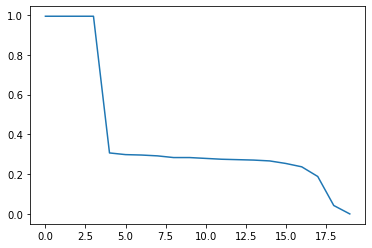

In [49]:
pd.DataFrame(thres)[1].plot()

In [50]:
feature_counts = feature_counts.sort_values(ascending=False)

In [51]:
feature_counts[feature_counts>0]

1752    1430
595     1333
1751    1209
514     1203
513     1173
        ... 
587        1
554        1
766        1
813        1
758        1
Length: 148, dtype: int64

<AxesSubplot:>

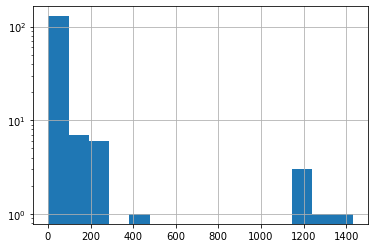

In [52]:
feature_counts[feature_counts>0].hist(log=True, bins=15)

## TEM_links

In [21]:
from torch_geometric.loader import NeighborLoader

In [96]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_tem('dataset/Venice_tem')
data = dataset[0]

In [97]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [98]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [99]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [100]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.38it/s]


In [101]:
test_Homo(model, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.17it/s]


(0.7332217283856506,
 1.619803889636518,
 99.7229916897507,
 99.7229916897507,
 0.7807017667141648,
 80.88642659279779)

In [103]:
test_Homo(model, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 23.92it/s]


(0.8056002129626468,
 1.6308585041262247,
 95.1219512195122,
 99.01477832512315,
 0.7454844061377013,
 78.81773399014779)

In [104]:
test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.48it/s]


(0.8034103550683434,
 1.6558503558238347,
 96.02385685884691,
 99.47916666666667,
 0.7256944527228674,
 77.60416666666667)

In [105]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 38.06it/s]


In [106]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [107]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.805953,1.631010,95.020325,9.901478e+01,0.749836,79.064039
std,0.000287,0.000073,0.172731,1.497956e-14,0.001898,0.478732
min,0.805414,1.630935,94.715447,9.901478e+01,0.747126,78.325123
25%,0.805793,1.630958,94.918699,9.901478e+01,0.748768,78.817734
50%,0.805968,1.630979,95.020325,9.901478e+01,0.749589,78.817734
75%,0.806075,1.631077,95.121951,9.901478e+01,0.751026,79.310345
max,0.806440,1.631118,95.325203,9.901478e+01,0.753695,79.802956


In [108]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.803585,1.655908,96.143141,9.947917e+01,0.730556,77.604167
std,0.000256,0.000158,0.167649,1.497956e-14,0.001793,0.245523
min,0.803203,1.655547,95.825050,9.947917e+01,0.727431,77.083333
25%,0.803394,1.655856,96.023857,9.947917e+01,0.730035,77.604167
50%,0.803593,1.655970,96.222664,9.947917e+01,0.730903,77.604167
75%,0.803733,1.655993,96.222664,9.947917e+01,0.730903,77.604167
max,0.804032,1.656063,96.421471,9.947917e+01,0.733507,78.125000


In [109]:
val_df.to_csv(args.save_dir + 'TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'TEM_test_metrics_transfer.csv', sep='\t')

## SPA_links

In [21]:
from torch_geometric.loader import NeighborLoader

In [110]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_spa('dataset/Venice_spa')
data = dataset[0]

In [111]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [112]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [113]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [114]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.05it/s]


In [115]:
test_Homo(model, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.03it/s]


(0.7324363260718264,
 1.6200073138498534,
 100.0,
 99.44598337950139,
 0.7765466367769109,
 80.33240997229917)

In [116]:
test_Homo(model, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.02it/s]


(0.7985899805780349,
 1.6324272866319554,
 95.52845528455285,
 99.50738916256158,
 0.7257799726401644,
 78.32512315270937)

In [117]:
test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.82it/s]


(0.8011263183523599,
 1.6576240280022223,
 96.62027833001989,
 99.47916666666667,
 0.7213541716337204,
 76.5625)

In [118]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.72it/s]


In [119]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [120]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.798616,1.632383,95.487805,99.507389,0.731691,78.275862
std,0.000227,0.000099,0.085699,0.000000,0.005712,0.363480
min,0.798338,1.632231,95.325203,99.507389,0.723317,77.832512
25%,0.798447,1.632329,95.528455,99.507389,0.728243,77.955665
50%,0.798598,1.632383,95.528455,99.507389,0.730706,78.325123
75%,0.798689,1.632429,95.528455,99.507389,0.735632,78.325123
max,0.799110,1.632544,95.528455,99.507389,0.740558,78.817734


In [121]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.801399,1.657411,96.580517,9.947917e+01,0.721094,77.135417
std,0.000255,0.000218,0.156821,1.497956e-14,0.002590,0.456039
min,0.801039,1.657132,96.421471,9.947917e+01,0.716146,76.562500
25%,0.801211,1.657247,96.421471,9.947917e+01,0.719401,77.083333
50%,0.801398,1.657386,96.620278,9.947917e+01,0.721354,77.083333
75%,0.801501,1.657514,96.620278,9.947917e+01,0.723307,77.083333
max,0.801903,1.657799,96.819085,9.947917e+01,0.723958,78.125000


In [122]:
val_df.to_csv(args.save_dir + 'SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SPA_test_metrics_transfer.csv', sep='\t')

## SOC_links

In [21]:
from torch_geometric.loader import NeighborLoader

In [123]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_soc('dataset/Venice_soc')
data = dataset[0]

In [124]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [125]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [126]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [127]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.53it/s]


In [128]:
test_Homo(model, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.79it/s]


(0.738962907375061,
 1.6204001081287036,
 99.7229916897507,
 99.44598337950139,
 0.7894736894940405,
 80.33240997229917)

In [130]:
test_Homo(model, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.83it/s]


(0.8110466261462468,
 1.6310881370394101,
 94.71544715447155,
 98.52216748768473,
 0.7619047681686326,
 79.3103448275862)

In [131]:
test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 23.08it/s]


(0.8238236066361307,
 1.6575363489488761,
 95.42743538767395,
 99.47916666666667,
 0.732638897995154,
 78.125)

In [132]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 29.25it/s]


In [133]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [134]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.811307,1.631118,94.898374,9.852217e+01,0.760591,79.261084
std,0.000181,0.000084,0.177966,1.497956e-14,0.003816,0.489866
min,0.811035,1.631001,94.715447,9.852217e+01,0.753695,78.817734
25%,0.811142,1.631049,94.715447,9.852217e+01,0.758621,78.817734
50%,0.811354,1.631105,94.918699,9.852217e+01,0.761084,79.310345
75%,0.811472,1.631200,95.071138,9.852217e+01,0.761084,79.310345
max,0.811508,1.631229,95.121951,9.852217e+01,0.768473,80.295567


In [135]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.823987,1.657562,95.447316,9.947917e+01,0.732118,78.177083
std,0.000367,0.000188,0.255802,1.497956e-14,0.002496,0.384305
min,0.823404,1.657290,95.029821,9.947917e+01,0.727431,77.604167
25%,0.823846,1.657448,95.228628,9.947917e+01,0.730903,78.125000
50%,0.824042,1.657567,95.526839,9.947917e+01,0.732639,78.125000
75%,0.824139,1.657680,95.626243,9.947917e+01,0.732639,78.515625
max,0.824624,1.657861,95.825050,9.947917e+01,0.736111,78.645833


In [136]:
val_df.to_csv(args.save_dir + 'SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SOC_test_metrics_transfer.csv', sep='\t')

## Masking Visual and Textual Features

In [28]:
model = SAGE(in_channels=data.x.shape[-1], hidden_channels = 512, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=5).to(device)

In [29]:
model.load_state_dict(torch.load(args.save_dir+'SAGE_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [30]:
model

SAGE(
  (convs): ModuleList(
    (0): SAGEConv(1753, 512)
    (1): SAGEConv(512, 512)
    (2): SAGEConv(512, 512)
    (3): SAGEConv(512, 512)
    (4): SAGEConv(512, 20)
  )
)

In [31]:
@torch.no_grad()
def test_Mask(model, loader, mask = None):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_1_val = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        
        if mask == 'vis':
            batch.x[:batch_size,:982] = torch.zeros(batch_size,982)
        elif mask == 'tex':
            batch.x[:batch_size,982:] = torch.zeros(batch_size,771)
        
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]
    
    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [32]:
test_Mask(model, train_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.92it/s]


(2.171622239981992,
 1.632508054334371,
 21.606648199445985,
 100.0,
 0.7543859719569663,
 78.94736842105263)

In [33]:
test_Mask(model, train_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.36it/s]


(0.7405485812977081,
 1.7726872670683504,
 100.0,
 81.16343490304709,
 0.10803324099722991,
 32.686980609418285)

In [34]:
test_Mask(model, val_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.57it/s]


(2.271485351450075,
 1.630924281228352,
 22.357723577235774,
 100.0,
 0.7758620783613233,
 78.81773399014779)

In [35]:
test_Mask(model, val_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.13it/s]


(0.7868161172401614,
 1.8005158537127115,
 96.34146341463415,
 71.92118226600985,
 0.07389162561576355,
 18.226600985221676)

In [36]:
test_Mask(model, test_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.23it/s]


(2.267704428782757,
 1.6548299727340539,
 23.45924453280318,
 99.47916666666667,
 0.7743055646618208,
 77.08333333333333)

In [37]:
test_Mask(model, test_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 13.96it/s]


(0.7934355283115303,
 1.8172860238701105,
 96.62027833001989,
 77.60416666666667,
 0.0798611119389534,
 21.875)

In [38]:
val_numbers_vis = []
val_numbers_tex = []
test_numbers_vis = []
test_numbers_tex = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers_vis.append(test_Mask(model, val_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    val_numbers_tex.append(test_Mask(model, val_loader, 'tex'))
    
    set_seed_everywhere(seed, args.cuda)
    test_numbers_vis.append(test_Mask(model, test_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers_tex.append(test_Mask(model, test_loader, 'tex'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.94it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.21it/s]


In [39]:
val_df_vis = pd.DataFrame(val_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
val_df_tex = pd.DataFrame(val_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_vis = pd.DataFrame(test_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_tex = pd.DataFrame(test_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [40]:
val_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,2.273715,1.631051,22.337398,100.0,0.777915,79.261084
std,0.001810,0.000224,0.223680,0.0,0.005035,0.431328
min,2.269818,1.630612,21.951220,100.0,0.769294,78.817734
25%,2.273107,1.630950,22.154472,100.0,0.774425,78.817734
50%,2.273843,1.631037,22.357724,100.0,0.777915,79.310345
75%,2.274964,1.631199,22.560976,100.0,0.781404,79.679803
max,2.275932,1.631404,22.560976,100.0,0.785714,79.802956


In [41]:
val_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.787288,1.800153,96.077236,70.295567,0.077094,19.704433
std,0.000459,0.000463,0.254404,0.616584,0.004086,0.985222
min,0.786485,1.799571,95.731707,69.458128,0.068144,17.241379
25%,0.787002,1.799766,95.934959,69.950739,0.076355,19.704433
50%,0.787295,1.800067,96.138211,70.443350,0.077176,19.704433
75%,0.787667,1.800520,96.138211,70.443350,0.078818,20.197044
max,0.787912,1.800971,96.544715,71.428571,0.082923,20.689655


In [42]:
test_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.266135,1.654548,23.618290,99.166667,0.774566,77.656250
std,0.002176,0.000358,0.225704,0.268957,0.002590,0.456039
min,2.262557,1.653949,23.260437,98.958333,0.771701,77.083333
25%,2.264983,1.654285,23.459245,98.958333,0.772352,77.213542
50%,2.266050,1.654528,23.658052,98.958333,0.774306,77.604167
75%,2.267182,1.654826,23.658052,99.479167,0.776259,78.125000
max,2.270030,1.655055,24.055666,99.479167,0.779514,78.125000


In [43]:
test_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.793832,1.817320,96.799205,77.187500,0.080903,22.447917
std,0.000429,0.000630,0.112852,0.878410,0.006709,1.376901
min,0.793258,1.816637,96.620278,75.520833,0.067708,19.270833
25%,0.793534,1.817036,96.819085,77.083333,0.081163,22.005208
50%,0.793744,1.817087,96.819085,77.343750,0.082465,22.656250
75%,0.794065,1.817295,96.819085,77.604167,0.084418,23.437500
max,0.794706,1.818721,97.017893,78.645833,0.087674,23.958333


In [44]:
val_df_vis.to_csv(args.save_dir + 'vis_masked_val_metrics.csv', sep='\t')
val_df_tex.to_csv(args.save_dir + 'tex_masked_val_metrics.csv', sep='\t')
test_df_vis.to_csv(args.save_dir + 'vis_masked_test_metrics.csv', sep='\t')
test_df_tex.to_csv(args.save_dir + 'tex_masked_test_metrics.csv', sep='\t')

## Using kNN Feature

In [97]:
def initialization_knn():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0]
    data.n_id = torch.arange(data.num_nodes)
    edge_index = knn_graph(data.x[:,:982].to(device), k=3, loop=False, cosine=True)
    data.edge_index = edge_index
    data = data.to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = SAGE(in_channels=data.x.shape[-1], hidden_channels = 512, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=5).to(device)
    return data, model, train_loader, val_loader, test_loader

In [98]:
def training_loop_knn(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization_knn()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop_knn(verbose=True)

In [100]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_Homo('dataset/Venice_homo')
data_0 = dataset[0]

In [101]:
edge_index = knn_graph(data_0.x[:,:982].to(device), k=3, loop=False, cosine=True)

In [102]:
data_0.edge_index = edge_index
data_0 = data_0.to(device)
data_0

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 8853], edge_attr=[1071977])

In [103]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [104]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [105]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [106]:
model = SAGE(in_channels=data_0.x.shape[-1], hidden_channels = 512, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=5).to(device)

In [107]:
model.load_state_dict(torch.load(args.save_dir+'SAGE_knn_feature/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [108]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 75.91it/s]


In [109]:
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 233.67it/s]


(0.7405274784465906,
 1.6204533534036778,
 100.0,
 99.7229916897507,
 0.7783933623675825,
 82.54847645429363)

In [110]:
test_Homo(model, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 66.97it/s]


(0.8412722705340967,
 1.6451545190341368,
 91.46341463414635,
 100.0,
 0.7422003346710957,
 77.33990147783251)

In [111]:
test_Homo(model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.93it/s]


(0.8280698758944366,
 1.6704634825388591,
 95.02982107355865,
 98.4375,
 0.6935763930281004,
 76.04166666666667)

In [112]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 271.61it/s]


In [113]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [114]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,10.0,10.0000,1.000000e+01
mean,8.412721e-01,1.645154e+00,9.146341e+01,100.0,0.7422,7.733990e+01
std,1.233101e-07,5.549804e-08,1.497956e-14,0.0,0.0000,1.497956e-14
min,8.412720e-01,1.645154e+00,9.146341e+01,100.0,0.7422,7.733990e+01
25%,8.412720e-01,1.645154e+00,9.146341e+01,100.0,0.7422,7.733990e+01
50%,8.412721e-01,1.645154e+00,9.146341e+01,100.0,0.7422,7.733990e+01
75%,8.412722e-01,1.645154e+00,9.146341e+01,100.0,0.7422,7.733990e+01
max,8.412724e-01,1.645154e+00,9.146341e+01,100.0,0.7422,7.733990e+01


In [115]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,10.000000,10.0000,1.000000e+01,1.000000e+01
mean,8.280698e-01,1.670463e+00,95.029821,98.4375,6.935764e-01,7.604167e+01
std,9.614008e-08,1.976403e-07,0.000000,0.0000,1.170278e-16,1.497956e-14
min,8.280697e-01,1.670463e+00,95.029821,98.4375,6.935764e-01,7.604167e+01
25%,8.280698e-01,1.670463e+00,95.029821,98.4375,6.935764e-01,7.604167e+01
50%,8.280698e-01,1.670463e+00,95.029821,98.4375,6.935764e-01,7.604167e+01
75%,8.280699e-01,1.670463e+00,95.029821,98.4375,6.935764e-01,7.604167e+01
max,8.280700e-01,1.670464e+00,95.029821,98.4375,6.935764e-01,7.604167e+01


In [116]:
val_df.to_csv(args.save_dir + 'knn_val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'knn_test_metrics.csv', sep='\t')

In [117]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [118]:
train_state

{'stop_early': True,
 'early_stopping_step': 30,
 'early_stopping_best_ATT_acc_val': 92.6829268292683,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.776735078451071,
 'learning_rate': 0.001,
 'epoch_index': 76,
 'train_loss': [4.079040586948395,
  3.597453316052755,
  3.31153013308843,
  2.9931045174598694,
  2.793036421140035,
  2.7115094860394797,
  2.646265963713328,
  2.610660672187805,
  2.5842005014419556,
  2.549887776374817,
  2.5355554024378457,
  2.517131825288137,
  2.502668301264445,
  2.4962843855222068,
  2.4849180579185486,
  2.480564912160238,
  2.4669495820999146,
  2.457028806209564,
  2.452991763750712,
  2.441280722618103,
  2.441769540309906,
  2.438609302043915,
  2.4342857201894126,
  2.4341718355814614,
  2.4290005962053933,
  2.4356675942738852,
  2.4316309293111167,
  2.428731143474579,
  2.4142324725786843,
  2.4095099568367004,
  2.405249377091726,
  2.395916302998861,
  2.391369680563608

In [119]:
with open(args.save_dir+'SAGE_knn_feature/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
with open(args.save_dir+'SAGE_knn_feature/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [121]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [122]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,64.532020,69.252078,30.487805,28.808864,15.270936,20.775623,0.011080,0.002463
1,68.472906,70.360111,39.634146,44.598338,21.182266,23.822715,0.065097,0.044335
2,81.280788,79.501385,54.878049,62.049861,46.798030,40.720222,0.181440,0.228243
3,80.788177,80.332410,75.406504,73.684211,50.246305,44.875346,0.261311,0.324302
4,82.266010,79.224377,80.081301,82.825485,51.724138,44.044321,0.302862,0.366174
...,...,...,...,...,...,...,...,...
72,99.507389,100.000000,86.788618,98.891967,80.295567,81.717452,0.816713,0.713465
73,99.014778,100.000000,87.398374,99.168975,76.847291,85.595568,0.790859,0.760263
74,99.507389,100.000000,86.382114,98.614958,80.788177,85.318560,0.825485,0.745484
75,100.000000,99.722992,88.414634,99.722992,79.310345,81.994460,0.809788,0.719212


<AxesSubplot:>

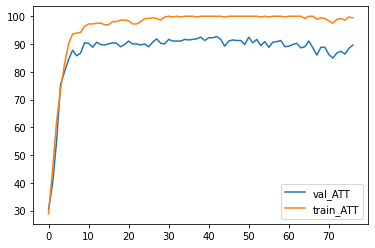

In [123]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

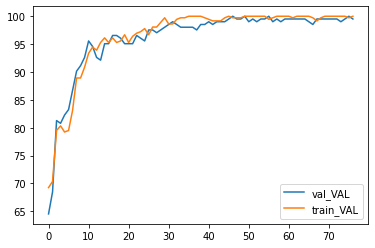

In [124]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

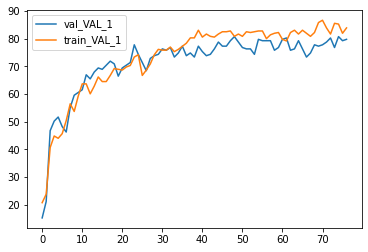

In [125]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

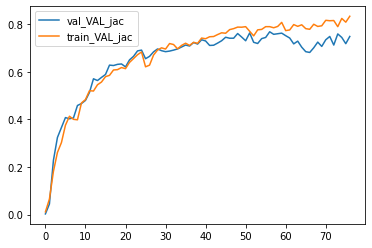

In [126]:
states[['val_VAL_jac','train_VAL_jac']].plot()

## Direct Prediction on VEN-XL

In [30]:
device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cpu


In [31]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset_XL = VEN_XL_Homo('dataset/Venice_XL_homo')
data_XL = dataset_XL[0]

In [32]:
data_XL.n_id = torch.arange(data_XL.num_nodes)
data_XL = data_XL.to(device)
data_XL

Data(num_nodes=80963, x=[80963, 1753], y=[80963, 20], att_lab=[80963], val_lab=[80963], node_type=[80963], train_mask=[80963], val_mask=[80963], test_mask=[80963], edge_index=[2, 290091503], edge_attr=[290091503], n_id=[80963])

In [33]:
from torch_geometric.loader import NeighborLoader

In [34]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.test_mask,
)
unlabel_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data_XL.train_mask + data_XL.val_mask + data_XL.test_mask),
)

In [35]:
model = SAGE(in_channels=data_XL.x.shape[-1], hidden_channels = 512, 
            out_channels = data_XL.y.shape[-1], dropout = 0.1, num_layers=5).to(device)

In [36]:
model.load_state_dict(torch.load(args.save_dir+'SAGE_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [37]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        edge_index = to_undirected(batch.edge_index)
        out = model(batch.x, edge_index)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [38]:
pred_train = predict_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [1:22:29<00:00, 13.67s/it]


In [39]:
pred_val = predict_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [2:19:07<00:00, 13.38s/it]


In [40]:
pred_test = predict_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [2:20:47<00:00, 13.54s/it]


In [41]:
pred_train[0]

tensor([4.0000e+00, 1.3500e-02, 9.0181e-01, 5.1935e-03, 2.7402e-03, 2.6608e-03,
        5.0749e-02, 1.2765e-02, 2.1375e-03, 8.4420e-03, 4.8005e-02, 1.2251e-01,
        1.3997e-01, 4.8272e-01, 5.3826e-02, 1.2716e-01, 4.9087e-03, 3.4084e-03,
        3.9171e-03, 4.9782e-03, 8.5965e-03])

In [42]:
preds = torch.vstack([pred_train, pred_val, pred_test]).cpu()

In [43]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [44]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [45]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.633332,0.057277,0.015404,0.028697,0.013699,0.175408,0.017617,0.012913,0.045652,0.236449,0.075887,0.074907,0.507199,0.027443,0.057173,0.003742,0.003125,0.002563,0.003162,0.008349
1.0,0.372060,0.024885,0.001671,0.005992,0.004620,0.570282,0.004931,0.002767,0.012791,0.232787,0.090658,0.085741,0.475766,0.018762,0.078831,0.002459,0.002418,0.001957,0.001963,0.008659
4.0,0.013500,0.901812,0.005193,0.002740,0.002661,0.050749,0.012765,0.002137,0.008442,0.048005,0.122507,0.139968,0.482724,0.053826,0.127160,0.004909,0.003408,0.003917,0.004978,0.008597
5.0,0.012320,0.908419,0.003180,0.002311,0.001448,0.058789,0.006633,0.001524,0.005376,0.047455,0.109753,0.180022,0.424235,0.048640,0.162746,0.005463,0.003685,0.003980,0.005649,0.008372
7.0,0.019720,0.111638,0.009613,0.015328,0.641959,0.029642,0.132666,0.009407,0.030028,0.054278,0.080581,0.196898,0.108560,0.013309,0.513272,0.008250,0.006606,0.004321,0.005031,0.008895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80956.0,0.118134,0.037216,0.006811,0.007781,0.208601,0.431651,0.030975,0.005117,0.153713,0.115312,0.172132,0.138203,0.352614,0.018661,0.180005,0.003568,0.004234,0.002963,0.002565,0.009743
80958.0,0.054562,0.223858,0.010701,0.006221,0.016337,0.557420,0.021155,0.003952,0.105794,0.120240,0.311770,0.104964,0.358159,0.015200,0.072098,0.002357,0.002840,0.002320,0.001984,0.008068
80959.0,0.943707,0.010062,0.001336,0.018816,0.004341,0.010590,0.005909,0.004065,0.001174,0.255703,0.303520,0.162176,0.174101,0.004954,0.086379,0.001446,0.002177,0.001417,0.001391,0.006736


In [46]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')

## Evaluation Metrics

In [79]:
preds = pd.read_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.633332,0.057277,0.015404,0.028697,0.013699,0.175408,0.017617,0.012913,0.045652,0.236449,0.075887,0.074907,0.507199,0.027443,0.057173,0.003742,0.003125,0.002563,0.003162,0.008349
1.0,0.372060,0.024885,0.001671,0.005992,0.004620,0.570282,0.004931,0.002767,0.012791,0.232787,0.090658,0.085741,0.475766,0.018762,0.078831,0.002459,0.002418,0.001957,0.001963,0.008659
2.0,0.017046,0.247266,0.016916,0.012148,0.426693,0.032296,0.175406,0.012946,0.059284,0.078895,0.068871,0.141617,0.120624,0.017452,0.527566,0.014055,0.007664,0.005529,0.008120,0.009607
3.0,0.041138,0.434027,0.025498,0.013622,0.087983,0.120305,0.214133,0.017339,0.045954,0.047354,0.158037,0.138289,0.267976,0.026557,0.328015,0.007392,0.005137,0.004794,0.006497,0.009951
4.0,0.013500,0.901812,0.005193,0.002740,0.002661,0.050749,0.012765,0.002137,0.008442,0.048005,0.122507,0.139968,0.482724,0.053826,0.127160,0.004909,0.003408,0.003917,0.004978,0.008597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.054562,0.223858,0.010701,0.006221,0.016337,0.557420,0.021155,0.003952,0.105794,0.120240,0.311770,0.104964,0.358159,0.015200,0.072098,0.002357,0.002840,0.002320,0.001984,0.008068
80959.0,0.943707,0.010062,0.001336,0.018816,0.004341,0.010590,0.005909,0.004065,0.001174,0.255703,0.303520,0.162176,0.174101,0.004954,0.086379,0.001446,0.002177,0.001417,0.001391,0.006736
80960.0,0.888731,0.018761,0.002371,0.031335,0.005960,0.035472,0.008148,0.006448,0.002774,0.339152,0.181970,0.155669,0.128935,0.004691,0.171414,0.002452,0.002963,0.001756,0.001853,0.009145


In [80]:
pred = torch.tensor(np.array(preds)).to(device)

In [81]:
eval_df = pd.DataFrame(('val_ATT_loss', 'val_VAL_loss', 'val_ATT_acc', 'val_VAL_acc', 'val_VAL_acc_k', 'val_VAL_jac_k'), columns=['name'])

In [82]:
(data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]).size()

torch.Size([51491])

In [60]:
train_ATT_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)

In [157]:
train_ATT_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)

In [61]:
eval_df['train'] = pd.DataFrame((train_ATT_loss, train_VAL_loss, train_ATT_acc, train_VAL_acc, train_VAL_acc_k, train_VAL_jac_k))

In [63]:
val_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)

In [159]:
val_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)

In [64]:
eval_df['val'] = pd.DataFrame((val_ATT_loss, val_VAL_loss, val_ATT_acc, val_VAL_acc, val_VAL_acc_k, val_VAL_jac_k))

In [65]:
test_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]) * data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)

In [161]:
test_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)

In [66]:
eval_df['test'] = pd.DataFrame((test_ATT_loss, test_VAL_loss, test_ATT_acc, test_VAL_acc, test_VAL_acc_k, test_VAL_jac_k))

In [67]:
eval_df

,name,train,val,test
0,val_ATT_loss,1.756584,1.739774,1.740664
1,val_VAL_loss,2.245626,2.239503,2.238977
2,val_ATT_acc,90.085574,94.692672,94.101626
3,val_VAL_acc,75.918403,78.186689,78.213783
4,val_VAL_acc_k,98.435474,98.688663,98.368495
5,val_VAL_jac_k,0.727310,0.755476,0.752813


In [68]:
eval_df.to_csv(args.save_dir+'eval_metrics_XL_trans.csv')

## Per-Class Metrics

In [69]:
from sklearn.metrics import confusion_matrix

In [83]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [71]:
test_ATT_conf = confusion_matrix(data_XL.y[data_XL.test_mask][:,:9].argmax(axis=1).cpu(), pred[data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL.y[data_XL.test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.test_mask][:,9:].cpu(),  pred[data_XL.test_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)).astype(int)

In [84]:
test_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)).astype(int)

In [85]:
test_ATT_conf

array([[1313,   21,    0,    9,    0,   45,    0,    1,    0],
       [   1, 3176,    0,    0,    0,   28,    6,    0,    0],
       [   0,    0,  247,    0,    0,    0,   16,    2,    0],
       [  47,   23,    0,  544,    2,    2,   14,    5,    0],
       [   7,   15,    0,    0, 2666,    3,   11,    1,    1],
       [   3,   23,    0,    1,    3, 1553,    0,    0,    0],
       [   1,   97,    4,    1,   10,    0, 2472,    8,    0],
       [  31,    6,   94,   19,    0,    0,  109,   54,    0],
       [   0,   16,    0,    0,   24,   48,    0,    0,   68]],
      dtype=int64)

In [86]:
test_VAL_conf

array([[ 603,    5,   13,   15,    0,   44,    0,    0,    0,    0,    0],
       [  63,  486,   55,   83,    0,  162,    0,    0,    0,    0,    0],
       [  52,   27,  839,   81,    0,  608,    0,    0,    0,    0,    0],
       [  46,   11,   19,  373,    0,   87,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  39,   10,   75,   34,    0, 3257,    0,    0,    0,    0,    0],
       [   3,    0,    4,    0,    0,    4,    0,    0,    0,    1,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    6,    0,    0,    0,    0,    0,    0,    3,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [87]:
test_VAL_conf_k

array([[1427,  624, 1139,  862,    0,  901,    0,    0,    0,    0,    0],
       [ 967, 1244, 2271, 2058,    1, 1667,    0,    0,    0,    0,    0],
       [1058,  847, 5797, 5169,    1, 5212,    0,    0,    0,    0,    0],
       [ 944,  935, 4751, 4903,    1, 4270,    0,    0,    0,    0,    0],
       [   1,    6,   18,   18,    0,   11,    0,    0,    0,    0,    0],
       [ 892,  388, 5301, 4754,    0, 5336,    0,    0,    0,    0,    0],
       [  16,    0,   31,    9,    0,   25,    4,    0,    0,   11,    0],
       [   3,    0,    6,    2,    0,    5,    2,    0,    0,    3,    0],
       [   8,    0,   14,    1,    0,    9,    2,    0,    0,    8,    0],
       [   9,    0,   19,    2,    0,   12,    4,    0,    0,   11,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [88]:
data_XL.val_mask[data_XL.val_mask + data_XL.train_mask]

tensor([ True,  True, False,  ...,  True,  True,  True])

In [55]:
val_ATT_conf = confusion_matrix(data_XL.y[data_XL.val_mask][:,:9].argmax(axis=1).cpu(), pred[data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL.y[data_XL.val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.val_mask][:,9:].cpu(),  pred[data_XL.val_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)).astype(int)

In [89]:
val_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)).astype(int)

In [90]:
val_ATT_conf

array([[1305,    4,    0,    7,    1,   32,    1,    2,    0],
       [   1, 3262,    0,    0,    0,   33,    3,    0,    0],
       [   1,    1,  265,    0,    0,    0,   11,    2,    0],
       [  56,   25,    2,  565,    0,    3,   21,    8,    0],
       [   1,   15,    0,    1, 2654,    3,   10,    3,    0],
       [   2,   26,    0,    1,    4, 1455,    0,    0,    0],
       [   2,   72,    4,    0,    7,    0, 2533,   12,    0],
       [  25,    6,   80,   12,    0,    0,  109,   54,    0],
       [   1,   19,    0,    0,   24,   30,    0,    0,   93]],
      dtype=int64)

In [91]:
val_VAL_conf

array([[ 585,   10,   15,    8,    0,   49,    0,    0,    0,    0,    0],
       [  77,  458,   68,   88,    0,  138,    0,    0,    0,    0,    0],
       [  53,   23,  893,   73,    0,  602,    0,    0,    0,    0,    0],
       [  48,   13,   31,  423,    0,   83,    0,    0,    0,    0,    0],
       [   0,    0,    1,    3,    0,    0,    0,    0,    0,    0,    0],
       [  34,    8,   70,   36,    0, 3185,    0,    0,    0,    0,    0],
       [   1,    0,    2,    0,    0,    2,    0,    0,    0,    0,    0],
       [   1,    0,    2,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    6,    0,    0,    1,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [92]:
val_VAL_conf_k

array([[1434,  636, 1167,  878,    0,  901,    0,    0,    0,    0,    0],
       [1035, 1244, 2388, 2125,    0, 1743,    0,    0,    0,    0,    0],
       [1048,  879, 5786, 5115,    0, 5141,    0,    0,    0,    1,    0],
       [ 913,  953, 4683, 4840,    0, 4178,    0,    0,    0,    0,    0],
       [   0,    8,   22,   22,    0,   14,    0,    0,    0,    0,    0],
       [ 858,  393, 5245, 4713,    0, 5236,    0,    0,    0,    1,    0],
       [  13,    0,   38,   25,    0,   37,    1,    0,    0,    6,    0],
       [   2,    0,    3,    2,    0,    1,    0,    0,    0,    1,    0],
       [   8,    0,   16,    5,    0,   11,    1,    0,    0,    7,    0],
       [   8,    0,   17,    5,    0,   12,    1,    0,    0,    8,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [59]:
train_ATT_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,:9].argmax(axis=1).cpu(), pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].cpu(),  pred[data_XL.train_mask[data_XL.val_mask + data_XL.train_mask + data_XL.test_mask]][:,9:].cpu(),3)).astype(int)

In [93]:
train_ATT_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,:9].argmax(axis=1).cpu(), 
                                  pred[data_XL.train_mask][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                                pred[data_XL.train_mask][:,9:].cpu(),3)).astype(int)

In [94]:
train_ATT_conf

array([[1424,   15,    0,    2,    0,   51,    9,    0,    0],
       [   0, 2611,    0,    0,    0,   17,    8,    0,    0],
       [   1,    2,  109,    0,    0,    0,   26,    1,    0],
       [  56,   24,    0,  370,    0,    3,   24,    3,    0],
       [   2,   11,    0,    0, 2007,    1,   26,    3,    1],
       [   2,   24,    0,    0,    7, 1474,    0,    0,    0],
       [   3,   72,    2,    2,   10,    0, 2362,    6,    0],
       [  66,   13,   33,   32,    0,    0,  510,   31,    0],
       [   0,   17,    0,    0,   33,   29,    0,    0,   34]],
      dtype=int64)

In [95]:
train_VAL_conf

array([[ 901,   14,   19,   11,    0,   67,    0,    0,    0,    0,    0],
       [ 117,  684,  109,  210,    0,  258,    0,    0,    0,    0,    0],
       [  79,   37, 1411,  141,    0, 1147,    0,    0,    0,    0,    0],
       [  53,   18,   45,  806,    0,  121,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    1,    0,    0,    0,    0,    0],
       [  64,   14,  143,   86,    0, 4976,    0,    0,    0,    0,    0],
       [   3,    0,    7,    0,    0,   10,    0,    0,    0,    1,    0],
       [   1,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    7,    0,    0,    0,    0,    0,    0,    5,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [96]:
train_VAL_conf_k

array([[2143,  857, 1608, 1356,    0, 1425,    0,    0,    0,    0,    0],
       [1467, 1984, 3939, 3719,    0, 3003,    0,    0,    0,    0,    0],
       [1673, 1438, 9506, 8425,    0, 8550,    0,    0,    0,    0,    0],
       [1539, 1548, 7711, 7977,    0, 6959,    0,    0,    0,    0,    0],
       [   0,   23,   54,   54,    0,   31,    0,    0,    0,    0,    0],
       [1452,  603, 8485, 7652,    0, 8571,    0,    0,    0,    0,    0],
       [  33,    0,   57,   23,    0,   44,    4,    0,    0,   13,    0],
       [  15,    0,   18,    5,    0,   14,    0,    0,    0,    2,    0],
       [  10,    0,   19,    3,    0,   10,    4,    0,    0,   11,    0],
       [  17,    0,   28,    6,    0,   16,    4,    0,    0,   13,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [97]:
pd.concat([pd.DataFrame(train_ATT_conf),pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf),pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf_k),pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_XL_trans.csv')

In [98]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [99]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [100]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [101]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [102]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [103]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         0.945284  0.935852   
          Urban Form Elements                       0.989100  0.940480   
          Gastronomy                                0.932075  0.715942   
          Interior Scenery                          0.854003  0.947735   
          Natural Features and Land-scape Scenery   0.985947  0.985582   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.025000  1.000000   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.000000  0.000000   
          Criterion x                               0.470588  1.000000   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.940544  
          Urban Form Elements                      0.964177  
          Gastronomy                               0.809836  
          Interior Scenery                         0.898431  
          Natural Features and Land-scape Scenery  0.985764  
...                                                     ...  
val_VAL_k Criterion vii                            0.048780  
          Criterion viii                           0.000000  
          Criterion ix                             0.000000  
          Criterion x                              0.640000  
          Others                                   0.000000  

[62 rows x 3 columns]

In [104]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_XL_trans.csv')

In [73]:
pred_unlab = predict_Homo(model, unlabel_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 921/921 [3:14:16<00:00, 12.66s/it]


In [74]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [75]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [76]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.633332,0.057277,0.015404,0.028697,0.013699,0.175408,0.017617,0.012913,0.045652,0.236449,0.075887,0.074907,0.507199,0.027443,0.057173,0.003742,0.003125,0.002563,0.003162,0.008349
1.0,0.372060,0.024885,0.001671,0.005992,0.004620,0.570282,0.004931,0.002767,0.012791,0.232787,0.090658,0.085741,0.475766,0.018762,0.078831,0.002459,0.002418,0.001957,0.001963,0.008659
2.0,0.017046,0.247266,0.016916,0.012148,0.426693,0.032296,0.175406,0.012946,0.059284,0.078895,0.068871,0.141617,0.120624,0.017452,0.527566,0.014055,0.007664,0.005529,0.008120,0.009607
3.0,0.041138,0.434027,0.025498,0.013622,0.087983,0.120305,0.214133,0.017339,0.045954,0.047354,0.158037,0.138289,0.267976,0.026557,0.328015,0.007392,0.005137,0.004794,0.006497,0.009951
4.0,0.013500,0.901812,0.005193,0.002740,0.002661,0.050749,0.012765,0.002137,0.008442,0.048005,0.122507,0.139968,0.482724,0.053826,0.127160,0.004909,0.003408,0.003917,0.004978,0.008597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.054562,0.223858,0.010701,0.006221,0.016337,0.557420,0.021155,0.003952,0.105794,0.120240,0.311770,0.104964,0.358159,0.015200,0.072098,0.002357,0.002840,0.002320,0.001984,0.008068
80959.0,0.943707,0.010062,0.001336,0.018816,0.004341,0.010590,0.005909,0.004065,0.001174,0.255703,0.303520,0.162176,0.174101,0.004954,0.086379,0.001446,0.002177,0.001417,0.001391,0.006736
80960.0,0.888731,0.018761,0.002371,0.031335,0.005960,0.035472,0.008148,0.006448,0.002774,0.339152,0.181970,0.155669,0.128935,0.004691,0.171414,0.002452,0.002963,0.001756,0.001853,0.009145


In [77]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')